## my own work with reference: https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/

## iris classification
### two ways to implement:
## 1, targets are long integers between [0,1, ... n-1], use softmax in model
## 1b, targets are long integers between [0,1, ... n-1], no softmax in model, but when Eval(), manually apply softmax to y_pred(or simply  torch.max(outputs, 1)), see: https://stackoverflow.com/questions/70303466/do-i-need-to-apply-the-softmax-function-anywhere-in-my-multi-class-classificatio
## 2, targets are one-hot encoded,no softmax in model

## for nn.ReLU
nn.ReLU() creates an nn.Module which you can add e.g. to an nn.Sequential model. nn.functional.relu on the other side is just the functional API call to the relu function, so that you can add it e.g. in your forward method yourself.

so if you are using nn.ReLU, you have to create it in __init__() first, then use it in forward()
## error2 ran into: expected scalar type Long but found Float:
crossentropy expect result to be integer long

## want to increase accuracy? https://www.kaggle.com/code/juiyangchang/cnn-with-pytorch-0-995-accuracy/notebook


# The regularization techniques help to improve a model and allows it to converge faster. 
# We have several regularization tools at our end, some of them are early stopping, dropout, weight initialization techniques, and batch normalization. 
# The regularization helps in preventing the over-fitting of the model and the learning process becomes more efficient.

In [3]:
import torch
from torch import nn
from sklearn import datasets
import tqdm

In [4]:
iris_data=datasets.load_iris()

In [105]:
features= iris_data['data']
targets = iris_data['target']

In [106]:
targets

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## nn.Linear expecting float32, so do use following dtype

### crossentropy expect result to be integer long

In [107]:
from sklearn.model_selection import train_test_split
features = torch.tensor(features, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.long)
# features = torch.tensor(features)
# targets = torch.tensor(targets)

X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size= 0.7, shuffle=True)

In [108]:
X_train.shape, y_train.shape, X_train.dtype, y_train.dtype

(torch.Size([105, 4]), torch.Size([105]), torch.float32, torch.int64)

In [82]:
import torch.nn.functional as F

In [83]:
class MultiClassModel(nn.Module):
    def __init__(self, input_dim, n_category, hidden=8):
        super(MultiClassModel,self).__init__()
        self.f1=nn.Linear(input_dim, hidden)
        self.act = nn.ReLU()
        self.f2=nn.Linear(hidden, n_category)
    def forward(self, x):
        x= self.act(self.f1(x))
        x=F.softmax(self.f2(x), dim=1)
        return x
model = MultiClassModel(4, 3)
loss_func= nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        

In [143]:
def train(X_train, y_train, n_epoch, batch_size):
    batches_per_epoch = len(X_train)//batch_size
    model.train()
    for epoch in range(n_epoch):
        with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
            bar.set_description(f"Epoch {epoch}")
            for i in bar:
                start=i*batch_size
                X_batch=X_train[start:start+batch_size]
                y_batch=y_train[start:start+batch_size]
                y_pred = model(X_batch)
                # print(f"y_pred:{y_pred}, y_batch:{y_batch}")
                # print(f"y_batch:{y_batch}")
                loss = loss_func(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                with torch.no_grad():
                    y_test_pred=model(X_test)
                    correct = (torch.argmax(y_test_pred, dim=1) == y_test).type(torch.FloatTensor).mean()
                # print(loss.item())
                bar.set_postfix(
                loss=loss.item(),
                acc=correct.item())
                

In [ ]:
train(X_train, y_train, 200, len(X_train))

### one hot encoding

In [187]:
class MultiClassModel2(nn.Module):
    def __init__(self, input_dim, n_category, hiddens=[16,8]):
        super(MultiClassModel2,self).__init__()
        
        self.ffirst=nn.Linear(input_dim, hiddens[0])
        self.middlelayers=[]
        for i in range(0,len(hiddens)-1):
            print("added one middle  layer")
            self.middlelayers.append(nn.Linear(hiddens[i],hiddens[i+1]))
        self.flast=nn.Linear(hiddens[-1], n_category)

        self.act = nn.ReLU()
    def forward(self, x):
        
        x= self.act(self.ffirst(x))
        for l in self.middlelayers:
            x = self.act(l(x))
        x=self.flast(x)
        return x
    


In [153]:
from sklearn.preprocessing import OneHotEncoder

features= iris_data['data']
targets = iris_data['target']
targets = targets.reshape(-1,1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(targets)
targets = ohe.transform(targets)



In [163]:
features = torch.tensor(features, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size= 0.7, shuffle=True)
X_train.shape, y_train.shape, X_train.dtype, y_train.dtype

(torch.Size([105, 4]), torch.Size([105, 3]), torch.float32, torch.float32)

In [177]:

def train2(X_train, y_train, nepoch):
    model2.train()
    train_losses=[]
    test_losses=[]
    train_accs=[]
    test_accs=[]
    for epoch in range(nepoch):
        y_pred = model2(X_train)
        loss = loss_func(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss.item())
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_train, 1)).float().mean()
        train_accs.append(acc)
        with torch.no_grad():
            y_test_pred= model2(X_test)
            test_loss = loss_func(y_test_pred,y_test).item()
            test_acc= (torch.argmax(y_test_pred, 1) == torch.argmax(y_test, 1)).float().mean()
            test_losses.append(test_loss)
            test_accs.append(test_acc)
        if epoch%20==0:
            print(f"epoch:{epoch}, loss: {loss.item()}, acc: {acc}, test_loss:{test_loss}, test_acc:{test_acc}")
    return train_losses, test_losses, train_accs, test_accs

In [194]:
model2 = MultiClassModel2(4, 3,[16])
print(model2)

MultiClassModel2(
  (ffirst): Linear(in_features=4, out_features=16, bias=True)
  (flast): Linear(in_features=16, out_features=3, bias=True)
  (act): ReLU()
)


In [195]:

loss_func= nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
train_losses, test_losses, train_accs, test_accs = train2(X_train,y_train, 500)

epoch:0, loss: 1.5735588073730469, acc: 0.3523809611797333, test_loss:1.7282267808914185, test_acc:0.2888889014720917
epoch:20, loss: 1.2469662427902222, acc: 0.3523809611797333, test_loss:1.3532555103302002, test_acc:0.2888889014720917
epoch:40, loss: 1.047002911567688, acc: 0.3523809611797333, test_loss:1.1138877868652344, test_acc:0.2888889014720917
epoch:60, loss: 0.9334465861320496, acc: 0.3523809611797333, test_loss:0.9698966145515442, test_acc:0.2888889014720917
epoch:80, loss: 0.8682421445846558, acc: 0.6571428775787354, test_loss:0.8907880783081055, test_acc:0.6222222447395325
epoch:100, loss: 0.8111750483512878, acc: 0.6761904954910278, test_loss:0.8297524452209473, test_acc:0.644444465637207
epoch:120, loss: 0.7559880018234253, acc: 0.6761904954910278, test_loss:0.7736490964889526, test_acc:0.644444465637207
epoch:140, loss: 0.7046601176261902, acc: 0.6761904954910278, test_loss:0.7213443517684937, test_acc:0.644444465637207
epoch:160, loss: 0.6586832404136658, acc: 0.676190

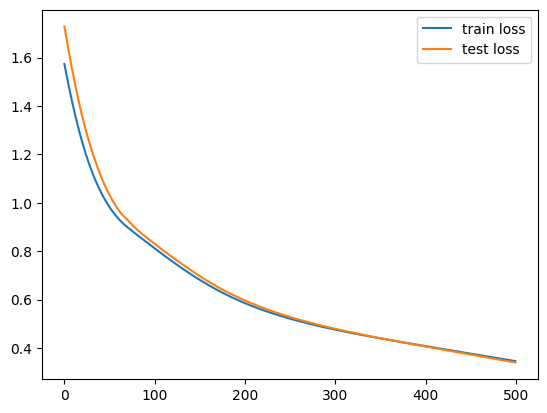

In [196]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

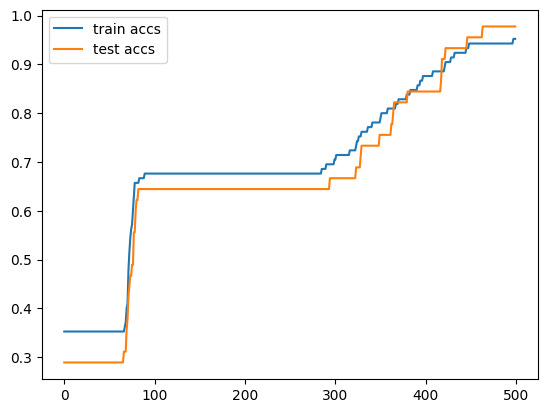

In [197]:
plt.plot(train_accs, label="train accs")
plt.plot(test_accs, label="test accs")
plt.legend()
plt.show()

## online example: https://janakiev.com/blog/pytorch-iris/

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x
    
model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()

In [146]:
import tqdm

EPOCHS  = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))
print(X_train.shape), print(y_train.shape), print(y_train[0]), X_train.dtype, y_train.dtype

torch.Size([120, 4])
torch.Size([120])
tensor(2)


(None, None, None, torch.float32, torch.int64)

## torch.argmax

In [147]:
for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    # print(f"y_pred:{y_pred}, y_train:{y_train}")
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [00:00<00:00, 2289.48it/s]
